#  Hello World!

###  **DSBA 6165: AI & Deep Learning**


## Goal

The goal of this lab activity is practicing the simple deep learning example to become familiar with the deep learning settings. In class, we have learned that the four key components of deep learning are 1) data, 2) model, 3) objective function, and 4) optimization algorithm. Let us review how these components work together to solve the popular MNIST problem.


## Data

Let us import basic PyTorch libraries

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


Define data transformations for preprocessing the MNIST dataset

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)) # these values are standard for MNIST dataset
])

Load the MNIST training and test datasets with transformations. PyTorch already has MNIST dataset and we can easily use it.

In [5]:
train_dataset = torchvision.datasets.MNIST(root='./data',
                                         train=True,
                                         transform=transform,
                                         download=True)

test_dataset = torchvision.datasets.MNIST(root='./data',
                                        train=False,
                                        transform=transform)

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



### Visualization of data

Let us take a look at some sample images in the dataset. The hand-written digits vary quite a lot, so it is not easy to identify the correct digits earlier, which is now quite easy problem for a simple deep learning model.   

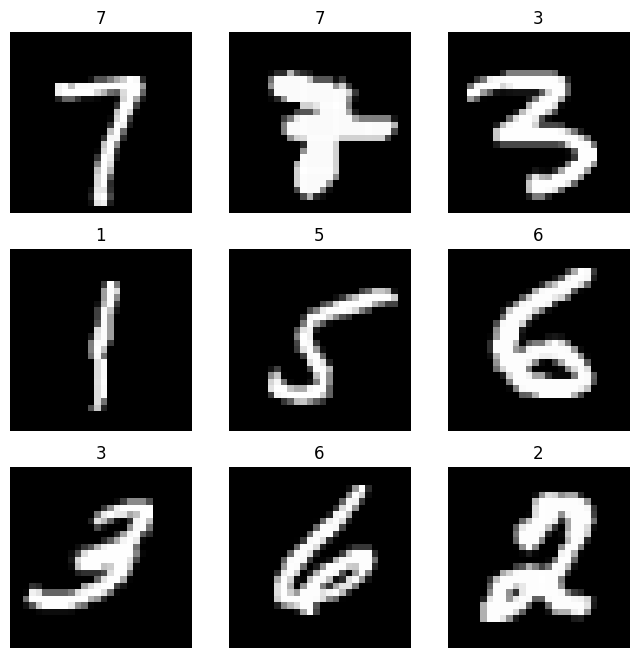

In [6]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

Create data loaders for batching and shuffling the datasets

In [7]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                         batch_size=64,
                                         shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                        batch_size=64,
                                        shuffle=False)


# Model

Now we build a neural network with three linear layers and one ReLU activation function in between. The model architecture consists of a series of layers designed for image classification. The [nn.Flatten](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html#flatten) layer transforms the 2D input images of size 28x28 into a 1D vector of size 784, which feeds into the fully connected layers. The [linear1](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear) layer maps this input size of 784 to 128 hidden units and uses the ReLU activation function to introduce non-linearity. The [linear2](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear) layer then maps the 128 units to 10 units, representing each digit class in the MNIST dataset. The [ReLU activation function](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU) - (nn.ReLU()) helps the model learn complex patterns by allowing only positive values to pass to the next layer.

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(28 * 28, 128)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x

Create an instance of the model and move it to the appropriate device (CPU or GPU)

In [9]:
model = Net()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(model)

Net(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=784, out_features=128, bias=True)
  (relu): ReLU()
  (linear2): Linear(in_features=128, out_features=10, bias=True)
)


Set up the loss function and optimizer for the model

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())


Function to train the model with given data, criterion, and optimizer

In [11]:
def train(model, train_loader, criterion, optimizer, num_epochs=5):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        print(f'Epoch [{epoch+1}/5], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%')

# Train the model
train(model, train_loader, criterion, optimizer)


Epoch [1/5], Loss: 0.2603, Accuracy: 92.35%
Epoch [2/5], Loss: 0.1118, Accuracy: 96.64%
Epoch [3/5], Loss: 0.0784, Accuracy: 97.58%
Epoch [4/5], Loss: 0.0583, Accuracy: 98.19%
Epoch [5/5], Loss: 0.0464, Accuracy: 98.50%


Function to evaluate the model on the test data and calculate accuracy

In [12]:
def evaluate(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')
    return accuracy

# Evaluate the model
evaluate(model, test_loader)


Test Accuracy: 97.57%


97.57

Function to visualize model predictions on test data

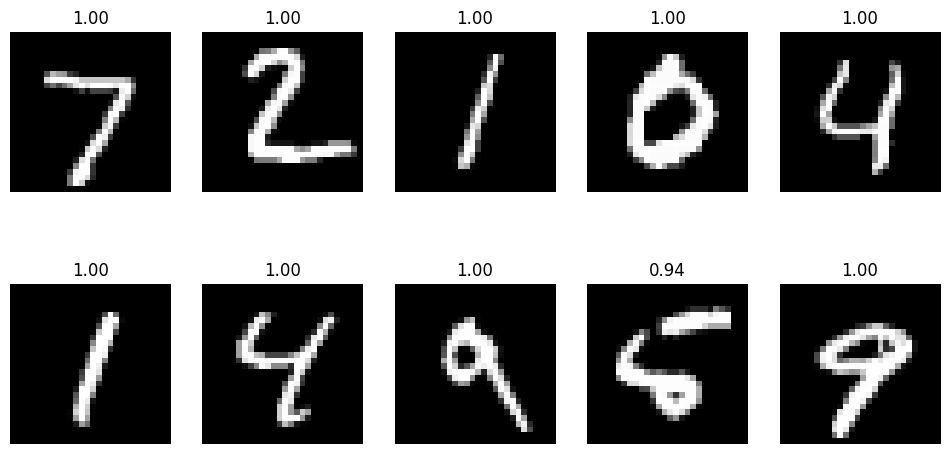

In [13]:
def visualize_predictions(model, test_loader):
    model.eval()
    images, labels = next(iter(test_loader))
    images = images[:10].to(device)

    with torch.no_grad():
        outputs = model(images)
        probs = torch.nn.functional.softmax(outputs, dim=1)

    fig = plt.figure(figsize=(12, 6))
    plt.tight_layout()

    for i in range(10):
        plt.subplot(2, 5, i+1)
        plt.imshow(images[i].cpu().squeeze(), cmap='gray', interpolation='none')
        plt.title(f"{torch.max(probs[i]).item():.2f}")
        plt.axis('off')

    plt.show()

# Visualize predictions
visualize_predictions(model, test_loader)


Function to visualize predictions and true labels on the test data

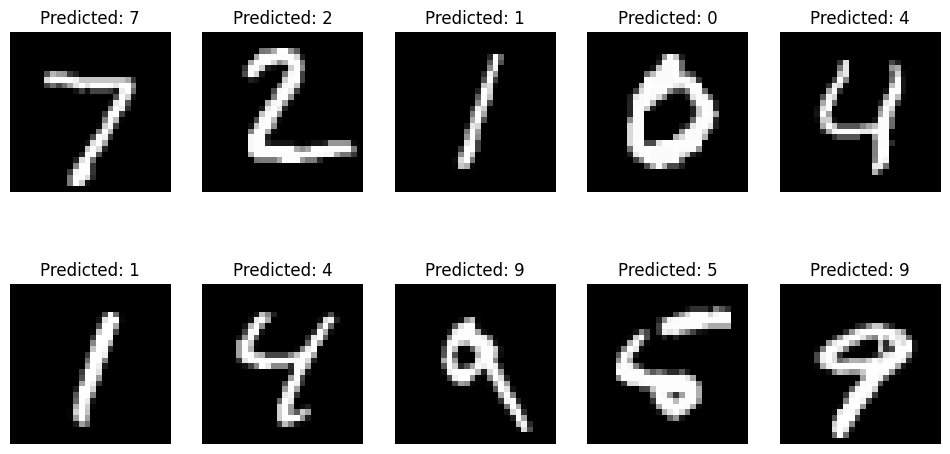

In [14]:
import torch
import matplotlib.pyplot as plt

def visualize_predictions(model, test_loader):
    model.eval()
    images, _ = next(iter(test_loader))
    images = images[:10].to(device)

    with torch.no_grad():
        outputs = model(images)
        # Get predicted digit (class with highest probability)
        _, predicted = torch.max(outputs.data, 1)

    fig = plt.figure(figsize=(12, 6))
    plt.tight_layout()

    for i in range(10):
        plt.subplot(2, 5, i+1)
        plt.imshow(images[i].cpu().squeeze(), cmap='gray', interpolation='none')
        plt.title(f"Predicted: {predicted[i].item()}")
        plt.axis('off')

    plt.show()

# Visualize predictions
visualize_predictions(model, test_loader)
